# Token Galaxy Explorer: Orthogonal Projections

**Goal:** Explore the token cloud from any angle by plotting orthogonal projections onto arbitrary dimension pairs.

**What this does:**
- Projects all 151,936 tokens onto a 2D plane defined by two eigenvector dimensions
- Colors points by causal norm (radial distance from origin)
- Automatically scales axes to show full extent in chosen dimensions
- Units in logometers (causal metric distances)

**Orthogonal projection:** All tokens projected straight onto the (dim_r, dim_s) plane, parallel to the perpendicular direction. No perspective, no foreshortening - like an architectural elevation view.

**To explore:** Just change DIM_R and DIM_S in the configuration cell and re-run!

## Configuration

**Set your dimensions here:**

In [9]:
# CHOOSE YOUR DIMENSIONS
# Dimensions range from 0 (smallest eigenvalue) to 2559 (largest eigenvalue)
# Try some interesting pairs:
#   - (2559, 2558): Two highest variance
#   - (2559, 0): Highest vs lowest variance  
#   - (1280, 1279): Middle of the spectrum
#   - (0, 1): Two lowest variance
#   - (2559, 1280): High vs medium

DIM_R = 1  # Horizontal axis
DIM_S = 0  # Vertical axis

# Plot parameters
FIGSIZE = (14, 14)  # Square plot
DPI = 100
POINT_SIZE = 0.5
ALPHA = 0.4
CMAP = 'viridis'  # purple = close, yellow = far

# Data paths
PROJECTIONS_PATH = '../data/vectors/token_eigenbasis_projections_qwen3_4b.pt'
EIGENBASIS_PATH = '../data/vectors/eigenbasis_qwen3_4b.pt'

print(f"Configuration:")
print(f"  Dimension R (horizontal): {DIM_R}")
print(f"  Dimension S (vertical): {DIM_S}")
print(f"  Figure size: {FIGSIZE}")
print(f"  Point size: {POINT_SIZE}, Alpha: {ALPHA}")

Configuration:
  Dimension R (horizontal): 1
  Dimension S (vertical): 0
  Figure size: (14, 14)
  Point size: 0.5, Alpha: 0.4


## Setup

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [11]:
print("Loading data...\n")

# Load eigenbasis
print(f"Loading eigenbasis from {EIGENBASIS_PATH}...")
eigenbasis_data = torch.load(EIGENBASIS_PATH, weights_only=False)
eigenvalues = eigenbasis_data['eigenvalues'].numpy()  # [hidden_dim]

# Load token projections (ALL tokens)
print(f"Loading projections from {PROJECTIONS_PATH}...")
projections_data = torch.load(PROJECTIONS_PATH, weights_only=False)
projections = projections_data['projections'].numpy()  # [vocab_size, hidden_dim]

vocab_size, hidden_dim = projections.shape

print(f"\n✓ Data loaded")
print(f"  Vocab size: {vocab_size:,}")
print(f"  Hidden dim: {hidden_dim:,}")

Loading data...

Loading eigenbasis from ../data/vectors/eigenbasis_qwen3_4b.pt...
Loading projections from ../data/vectors/token_eigenbasis_projections_qwen3_4b.pt...

✓ Data loaded
  Vocab size: 151,936
  Hidden dim: 2,560


## Compute Causal Norms

In [12]:
def compute_causal_norms(projections, eigenvalues):
    """
    Compute causal norms of projections in eigenbasis.
    
    Args:
        projections: [N, hidden_dim] array of eigenbasis coordinates
        eigenvalues: [hidden_dim] array of eigenvalues
    
    Returns:
        [N] array of causal norms (in logometers)
    """
    # ||v||_M = sqrt(sum_i lambda_i * v_i^2)
    weighted_squares = projections**2 * eigenvalues[np.newaxis, :]  # [N, hidden_dim]
    norms = np.sqrt(weighted_squares.sum(axis=1))  # [N]
    return norms

print("Computing causal norms for all tokens...")
causal_norms = compute_causal_norms(projections, eigenvalues)

print(f"\n✓ Causal norms computed")
print(f"\nRadial distance statistics:")
print(f"  Mean: {causal_norms.mean():.2f} logometers")
print(f"  Median: {np.median(causal_norms):.2f} logometers")
print(f"  Std: {causal_norms.std():.2f} logometers")
print(f"  Range: [{causal_norms.min():.2f}, {causal_norms.max():.2f}] logometers")

Computing causal norms for all tokens...

✓ Causal norms computed

Radial distance statistics:
  Mean: 54.13 logometers
  Median: 55.26 logometers
  Std: 7.90 logometers
  Range: [21.35, 85.29] logometers


## Convert Selected Dimensions to Logometers

In [13]:
def convert_to_logometers(projections, dim_r, dim_s, eigenvalues):
    """
    Convert eigenbasis projections to logometer coordinates for 2D plane.
    
    Args:
        projections: [N, hidden_dim] array
        dim_r: first dimension index
        dim_s: second dimension index
        eigenvalues: [hidden_dim] array
    
    Returns:
        r_logo: [N] array of r-coordinates in logometers
        s_logo: [N] array of s-coordinates in logometers
    """
    # Scale by sqrt(eigenvalue) to get logometer units
    r_logo = projections[:, dim_r] * np.sqrt(eigenvalues[dim_r])
    s_logo = projections[:, dim_s] * np.sqrt(eigenvalues[dim_s])
    return r_logo, s_logo

print(f"Converting dimensions {DIM_R} and {DIM_S} to logometer coordinates...\n")

r_coords, s_coords = convert_to_logometers(projections, DIM_R, DIM_S, eigenvalues)

print(f"Dimension {DIM_R} (r-axis):")
print(f"  Eigenvalue: {eigenvalues[DIM_R]:,.0f}")
print(f"  Range: [{r_coords.min():.2f}, {r_coords.max():.2f}] logometers")
print(f"  Width: {r_coords.max() - r_coords.min():.2f} logometers")
print(f"  Mean: {r_coords.mean():.2f} logometers")

print(f"\nDimension {DIM_S} (s-axis):")
print(f"  Eigenvalue: {eigenvalues[DIM_S]:,.0f}")
print(f"  Range: [{s_coords.min():.2f}, {s_coords.max():.2f}] logometers")
print(f"  Width: {s_coords.max() - s_coords.min():.2f} logometers")
print(f"  Mean: {s_coords.mean():.2f} logometers")

print("\n✓ Conversion complete")

Converting dimensions 1 and 0 to logometer coordinates...

Dimension 1 (r-axis):
  Eigenvalue: 315
  Range: [-4.88, 3.84] logometers
  Width: 8.72 logometers
  Mean: -1.21 logometers

Dimension 0 (s-axis):
  Eigenvalue: 95
  Range: [-7.86, 7.09] logometers
  Width: 14.95 logometers
  Mean: 2.53 logometers

✓ Conversion complete


## Determine Axis Limits

Set limits based on actual extent in the chosen dimensions (with 5% padding).

In [14]:
# Calculate ranges with padding
r_range = r_coords.max() - r_coords.min()
s_range = s_coords.max() - s_coords.min()

r_padding = 0.05 * r_range
s_padding = 0.05 * s_range

r_min = r_coords.min() - r_padding
r_max = r_coords.max() + r_padding
s_min = s_coords.min() - s_padding
s_max = s_coords.max() + s_padding

print(f"Axis limits (with 5% padding):")
print(f"  R (dim {DIM_R}): [{r_min:.2f}, {r_max:.2f}] logometers")
print(f"  S (dim {DIM_S}): [{s_min:.2f}, {s_max:.2f}] logometers")

Axis limits (with 5% padding):
  R (dim 1): [-5.31, 4.28] logometers
  S (dim 0): [-8.61, 7.84] logometers


## Color Map Setup

In [15]:
# Normalize colors based on causal norm range
norm = Normalize(vmin=causal_norms.min(), vmax=causal_norms.max())
cmap = cm.get_cmap(CMAP)

print(f"Color mapping:")
print(f"  Colormap: {CMAP}")
print(f"  Range: {causal_norms.min():.2f} - {causal_norms.max():.2f} logometers")
print(f"  Purple/dark = close to origin")
print(f"  Yellow/bright = far from origin")

Color mapping:
  Colormap: viridis
  Range: 21.35 - 85.29 logometers
  Purple/dark = close to origin
  Yellow/bright = far from origin


/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_56438/2097610775.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(CMAP)


## Plot: Orthogonal Projection

View the token galaxy projected onto the plane spanned by dimensions {DIM_R} and {DIM_S}.

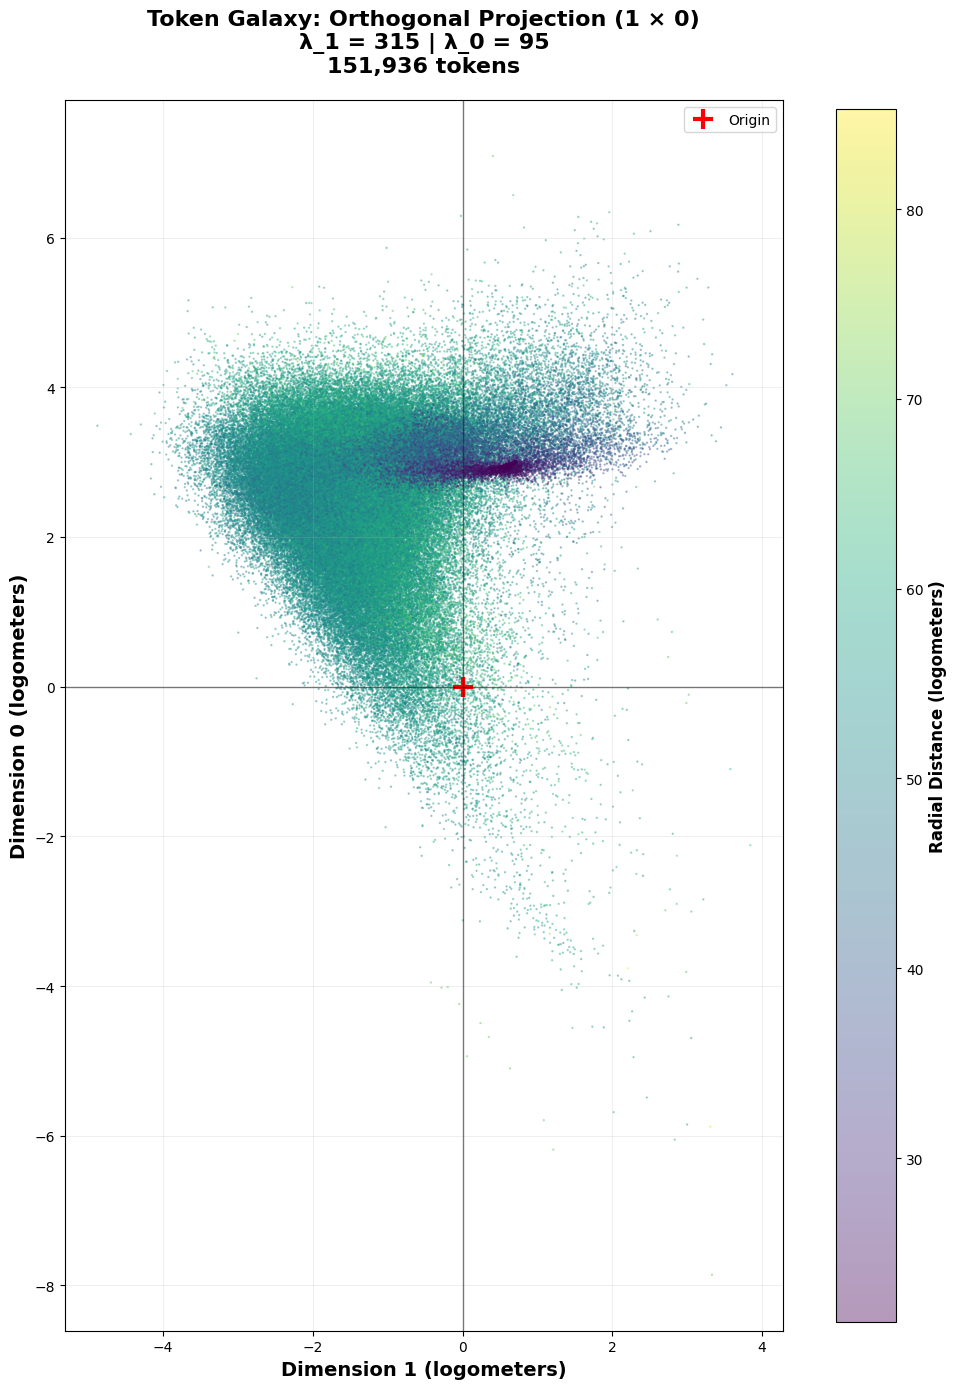


✓ Plot complete


In [16]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Scatter plot
scatter = ax.scatter(
    r_coords, s_coords,
    s=POINT_SIZE,
    alpha=ALPHA,
    c=causal_norms,
    cmap=cmap,
    norm=norm,
    rasterized=True
)

# Mark origin
ax.plot(0, 0, 'r+', markersize=15, markeredgewidth=3, label='Origin')

# Set axis limits (dynamic based on data extent)
ax.set_xlim(r_min, r_max)
ax.set_ylim(s_min, s_max)
ax.set_aspect('equal')

# Grid and axes
ax.grid(True, alpha=0.3, linewidth=0.5)
ax.axhline(0, color='black', linewidth=1, alpha=0.5)
ax.axvline(0, color='black', linewidth=1, alpha=0.5)

# Labels
ax.set_xlabel(f'Dimension {DIM_R} (logometers)', fontsize=14, fontweight='bold')
ax.set_ylabel(f'Dimension {DIM_S} (logometers)', fontsize=14, fontweight='bold')

# Title with eigenvalue info
ax.set_title(
    f'Token Galaxy: Orthogonal Projection ({DIM_R} × {DIM_S})\n'
    f'λ_{DIM_R} = {eigenvalues[DIM_R]:,.0f} | λ_{DIM_S} = {eigenvalues[DIM_S]:,.0f}\n'
    f'{vocab_size:,} tokens',
    fontsize=16,
    fontweight='bold',
    pad=20
)

# Legend
ax.legend(loc='upper right', fontsize=10)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Radial Distance (logometers)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Plot complete")

## Summary

**What you're seeing:**

This is an **orthogonal (orthographic) projection** of the 151,936-token cloud onto the 2D plane spanned by eigenvector dimensions {DIM_R} and {DIM_S}.

**Interpretation:**
- Every token is projected straight onto this plane (parallel projection)
- Color shows radial distance from origin in full 2560D space
- Axes scaled in logometers (causal metric distances)
- Origin marked with red + (you're floating here, looking at the cloud)

**To explore further:**
- Change DIM_R and DIM_S in the configuration cell
- Re-run from "Convert Selected Dimensions" onward
- Try different eigenvalue ranges:
  - High eigenvalues (2500-2559): directions with lots of variance
  - Low eigenvalues (0-100): compressed, low-variance directions
  - Mixed: see how the cloud looks from different angles

**Dimensions of interest:**
- **2559:** Maximum variance, radial shell structure visible in 09.3c
- **2558:** 3rd largest eigenvalue
- **0:** Minimum variance, cloud maximally compressed here